In [141]:
import json
import shutil
from pathlib import Path
import imageio
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline

In [142]:
base_path = Path('/mnt/ssd/kashin/ai_edge/segmentation')
val_path = base_path / 'seg_val_images'

with open('folds_split.json') as f:
    folds = json.load(f)

test_names = folds['0']

In [144]:
for name in test_names:
    path = base_path / 'seg_train_images' / (name + '.jpg')
    shutil.copy(path, val_path / (name + '.jpg'))

for name in test_names:
    path = base_path / 'seg_train_images' / (name + '.jpg')
    shutil.copy(path, val_path / (name + '.jpg'))

Predicting val images by script: predict.py

In [146]:
def get_triplet(i, solution='full_labels/val_full_full'):
    # nor_resize_jaccard/val_full
    name = test_names[i]
    annot_path = base_path / 'seg_train_annotations' / (name + '.png')
    img_path = val_path / (name + '.jpg')
    img_pr_path = base_path / 'runs' / solution / (name + '.png')
    
    annot = imageio.imread(annot_path) # transform_label_mask
    img = imageio.imread(img_path)
    img_pr = imageio.imread(img_pr_path)
    
    return annot, img, img_pr

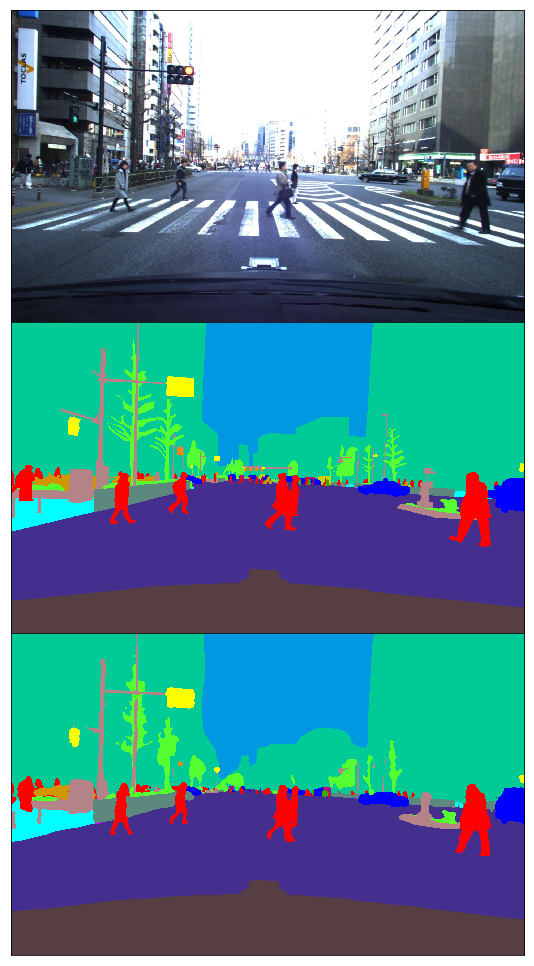

In [151]:
ann, img, pr = get_triplet(-1)

f, ax = plt.subplots(nrows=3, ncols=1, figsize=(5, 12))
ax[0].imshow(img)
ax[1].imshow(ann)
ax[2].imshow(pr)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])
f.tight_layout(pad=-8)

In [152]:
eval_names = ('car', 'pedestrian', 'lane', 'signal')
eval_colors = ((0, 0, 255), (255, 0, 0), (69, 47, 142), (255, 255, 0))

full_names = ('car', 'pedestrian', 'lane', 'bus', 'truck',
              'svehicle', 'motorbike', 'bicycle', 'signal',
              'signs', 'sky', 'building', 'natural', 'wall',
              'ground', 'sidewalk', 'roadshoulder', 'obstacle',
              'others', 'own')
full_colors = [[0, 0, 255], [255, 0, 0], [69, 47, 142], [193, 214, 0],
               [180, 0, 129], [255, 121, 166], [65, 166, 1],
               [208, 149, 1], [255, 255, 0], [255, 134, 0],
               [0, 152, 225], [0, 203, 151], [85, 255, 50],
               [92, 136, 125], [136, 45, 66], [0, 255, 255],
               [215, 0, 255], [180, 131, 135], [81, 99, 0], [86, 62, 67]]

def transform_label_mask(mask, colors, delta=1):
    # delta for undefined zero class, if not all image pixel are annotated
    label_mask = np.zeros(mask.shape[:2])
    for i, col in enumerate(colors):
        label = (mask == col).sum(axis=2) == 3
        label_mask[label] = i + delta
    return np.expand_dims(label_mask, -1)

In [153]:
ann_l = transform_label_mask(ann, eval_colors, 1)[:,:,0]
pr_l = transform_label_mask(pr, eval_colors, 1)[:,:,0]

In [154]:
def iou_per_class(target, predict, num_classes=5):
    ious = []
    for cls in range(num_classes):
        target_cl = target == cls
        predict_cl = predict == cls
        intersection = (predict_cl * target_cl).sum()

        union = target_cl.sum() + predict_cl.sum() - intersection + 1e-10
        iou = intersection / union
        ious.append(iou)
    return ious

## For all

In [156]:
all_ious = []
for i in tqdm_notebook(range(len(list(val_path.iterdir())))):
    ann, img, pr = get_triplet(i)
    ann_l = transform_label_mask(ann, eval_colors, 1)[:,:,0]
    pr_l = transform_label_mask(pr, eval_colors, 1)[:,:,0]
    ious = iou_per_class(ann_l, pr_l)
    all_ious.append(ious)

In [157]:
ious_df = pd.DataFrame(all_ious, columns=('back',) + eval_names)
ious_df['avg'] = ious_df.apply(lambda x: sum(x) / len(x), axis=1)

In [158]:
ious_df.head()

,back,car,pedestrian,lane,signal,avg
0,0.988463,0.967472,0.015544,0.964605,0.657368,0.718690
1,0.961868,0.829532,0.616163,0.932580,0.018826,0.671794
2,0.945466,0.735985,0.506555,0.911970,0.000000,0.619995
3,0.988215,0.902880,0.654137,0.975945,0.635052,0.831246
4,0.981998,0.834475,0.725999,0.936187,0.536967,0.803125


In [159]:
ious_df.describe()

,back,car,pedestrian,lane,signal,avg
count,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000
mean,0.973842,0.719485,0.389181,0.922138,0.269126,0.654754
std,0.022196,0.269481,0.297697,0.067079,0.286544,0.117248
min,0.818659,0.000000,0.000000,0.585636,0.000000,0.342481
25%,0.969326,0.622604,0.000000,0.907051,0.000000,0.564120
50%,0.979804,0.830621,0.466878,0.945784,0.176166,0.669039
75%,0.987011,0.916847,0.646386,0.965260,0.525945,0.732954
max,0.996442,0.970561,0.896758,0.988158,0.907348,0.885302


## The biggest errors

In [160]:
ious_df.sort_values('avg').head()

,back,car,pedestrian,lane,signal,avg
210,0.912538,0.048552,0.000000,0.751317,0.000000,0.342481
18,0.961368,0.000000,0.000000,0.785223,0.000000,0.349318
250,0.974904,0.000000,0.000000,0.927033,0.000000,0.380387
83,0.853168,0.000000,0.129405,0.603202,0.318404,0.380836
300,0.962811,0.000000,0.173135,0.804436,0.000000,0.388077


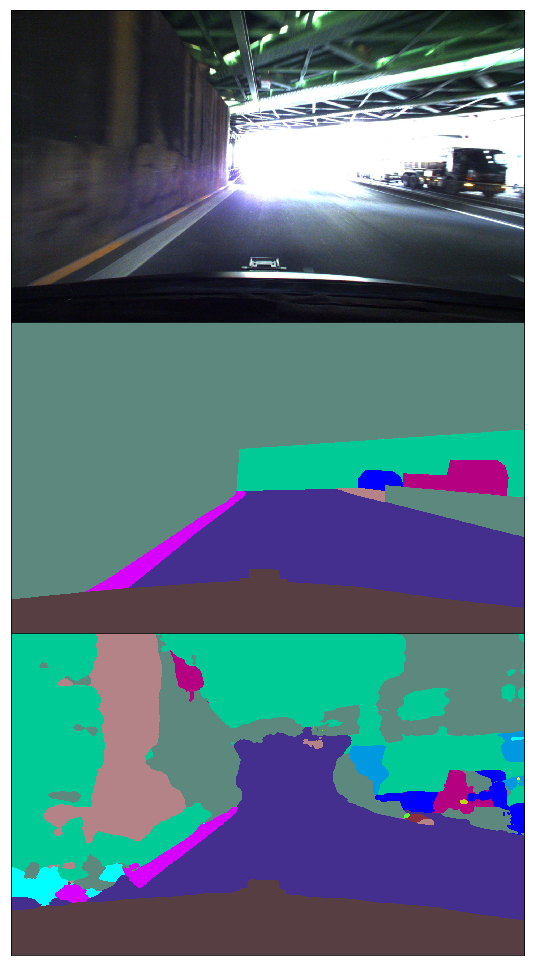

In [161]:
ann, img, pr = get_triplet(210)

f, ax = plt.subplots(nrows=3, ncols=1, figsize=(5, 12))
ax[0].imshow(img)
ax[1].imshow(ann)
ax[2].imshow(pr)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])

f.tight_layout(pad=-8)